# Problem Set 2

## Question 4

Do Exercise 26.12 in Hansen (2022). (I did this part by the help of Alessia and Wonjun)

In [54]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
from ipykernel import kernelapp as app
from statsmodels.nonparametric.kernel_regression import KernelReg as kr 
from scipy.stats import bootstrap
import matplotlib.pyplot as plt

# Import data
data = pd.read_stata("https://www.ssc.wisc.edu/~bhansen/econometrics/cps09mar.dta")
# Create 'education'=20 subset 
data_new= data[data.education == 20]
# Create experience variable
data_new['experience']= data_new['age'] - data_new['education'] - 6

data_new2 = data_new[data_new.experience <= 40]
data_new2['lwage']= np.log(data_new2['earnings']/(data_new2['hours']*data_new2['week']))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
reg=kr(data_new2['lwage'], data_new2['experience'], var_type='c', reg_type='lc', defaults=None)

In [50]:
results=reg.fit(data_predict=data_new2['experience'])
print(results)
type(results)


(array([3.71269031, 3.74417287, 3.56437988, ..., 3.81416576, 3.80444794,
       3.78026584]), array([[ 3.68123122e-05],
       [ 3.19348702e-05],
       [ 4.33929573e-05],
       ...,
       [ 8.90117411e-06],
       [ 1.27299656e-05],
       [-1.63410787e-05]]))


tuple

In [51]:
sum = 0
for sub in results:
    for i in sub:
        sum = sum + i
res = sum / len(results)

In [52]:
print(res)


[3366.66795772]


In [56]:
class MyKernelRegression():
    """
    single variable
    """
    h = 1
    
    def __init__(self,Y,X):
        self.Y = np.array(Y)
        self.X = np.array(X)
        self.n = len(Y)
        self.K = -1
        
    def fit(self, x, reg_type='ll', kernel_type='epanechnikov', h_type='undersmooth'):
        self.x = np.array(x)
        self.kernel_type = kernel_type
        self.h_type = h_type
        
        self.K = self._get_kernel_weight(x=self.x, kernel_type=self.kernel_type,h_type=self.h_type)
        
        self.f = self.density(x=self.x)
        
        if reg_type=='lc':
            self._Nadaraya_Watson(x=self.x)
        elif reg_type=='ll':
            self._Local_Linear(x=self.x)
            
    def density(self, x):
        """
        need _get_kernel_weight() first.
        """
        if len(self.K) < len(self.x):
            self.K = self._get_kernel_weight(x=self.x, kernel_type=self.kernel_type,h_type=self.h_type)
        n,X = self.n, self.X
        
        fhat = np.zeros(len(x))
        for i, xi in enumerate(x):
            fhat[i] = np.mean(self.K[i,:])
        self.f = fhat
        return fhat
    
    def _Nadaraya_Watson_point(self, x0):
        X,Y = self.X, self.Y
        K0 = self._get_kernel_weight(np.array([x0]), kernel_type=self.kernel_type,h_type=self.h_type)
        
        Yhat = np.sum(K0 * Y)/np.sum(K0)
        return Yhat
    
    def _Nadaraya_Watson(self, x):
        X,Y = self.X, self.Y
        
        Yhat = np.zeros(len(x))
        for i,xi in enumerate(x):
            Ki = self.K[i,:]
            Yhat[i] = np.sum(Y*Ki)/np.sum(Ki)
        self.Yhat = Yhat
        
        e2 = np.zeros(len(X))
        for i,Xi in enumerate(X):
            e2[i] = (Y[i] - self._Nadaraya_Watson_point(Xi))**2
        
        varhat = np.zeros(len(x))
        for i, xi in enumerate(x):
            sigma2 = np.sum(e2*Ki)/np.sum(Ki)
            var = (self.Rk * sigma2) / (self.f[i] * self.n * self.h)
            varhat[i] = var
        self.varhat = varhat
        self.se = np.sqrt(varhat)
        return Yhat
    
    def _Local_Linear_point(self, x0):
        X,Y = self.X, self.Y
        K0 = self._get_kernel_weight(np.array([x0]), kernel_type=self.kernel_type,h_type=self.h_type)
        K0 = K0.reshape(-1)
        
        Z0 = np.ones(self.n)
        Z1 = X-x0
        Z = np.column_stack([Z0,Z1])
        K = np.diag(K0)
        bhat = np.linalg.solve(Z.T@K@Z, Z.T@K@Y)
        Yhat = bhat[0]
        return Yhat
        
    def _Local_Linear(self, x):
        X,Y = self.X, self.Y
        
        bhat = np.zeros([2,len(x)])
        for i,xi in enumerate(x):
            Ki=self.K[i,:]
            Z0 = np.ones(self.n)
            Z1 = X-xi
            Z = np.column_stack([Z0,Z1])
            K = np.diag(Ki)
            bhat[:,i] = np.linalg.solve(Z.T@K@Z, Z.T@K@Y)
        self.bhat = bhat
        self.Yhat = bhat[0,:]
        
        e2 = np.zeros(len(X))
        for i, Xi in enumerate(X):
            e2[i] = (Y[i] - self._Local_Linear_point(Xi))**2
            
        varhat = np.zeros(len(x))
        for i, xi in enumerate(x):
            sigma2 = np.sum(e2*Ki)/np.sum(Ki)
            var = (self.Rk * sigma2) / (self.f[i] * self.n * self.h)
            varhat[i] = var
        self.varhat = varhat
        self.se = np.sqrt(varhat)
        
    def K_epanechnikov(self, u):
        """
        u: vector
        """
        self.kernel_type = 'epanechnikov'
        self.Rk = 3*(5**0.5)/25
        return np.max(np.column_stack([0.75*(1-u**2), np.zeros(len(u))]), axis=1)
    
    def _get_kernel_weight(self, x, kernel_type, h_type):
        """
        ex)
        x = [1, 2]
        X = [X1, X2, X3]
        
        K = [[K_h(1-X1), K_h(2-X1), K_h(3-X1)],
             [K_h(1-X2), K_h(2-X2), K_h(3-X2)]]
             
        i.e. K[i:] contains kernel weights for x_i
        """
        X = self.X
        n = self.n
        if self.kernel_type == 'epanechnikov':
            kernel = self.K_epanechnikov

        if self.h_type == 'undersmooth':
            h = (n*np.std(X))**(1/5)
            self.h = h
        
        K = np.zeros([len(x),len(X)])
        for i,xi in enumerate(x):
            K[i,:] = (1/h) * kernel((xi - X)/h)
        return K
        
    def plot(self, **karg):
        """
        karg: title
        """
        x, Yhat, se = self.x, self.Yhat, self.se
        
        fig, ax = plt.subplots(1,1)
        plt.plot(x,Yhat, '-')
        plt.plot(x,Yhat-1.96*se, '-.')
        plt.plot(x,Yhat+1.96*se, '-.')
        if karg['title']:
            plt.title(karg['title'])    
    

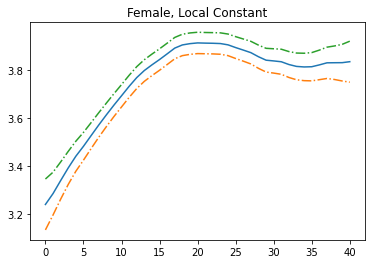

In [58]:
data_temp = data_new2[data_new2.female == 0]
Y = data_temp.lwage
X = data_temp.experience

x = np.array([i for i in range(41)])
res = MyKernelRegression(Y=Y,X=X)
res.fit(x, reg_type='lc')
res.plot(title='Female, Local Constant')

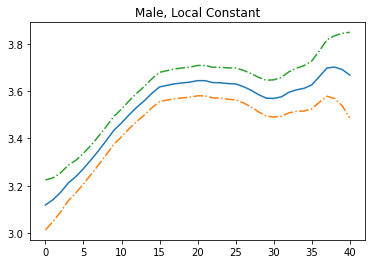

In [59]:
data_temp = data_new2[data_new2.female == 1]
Y = data_temp.lwage
X = data_temp.experience

x = np.array([i for i in range(41)])
res = MyKernelRegression(Y=Y,X=X)
res.fit(x, reg_type='lc')
res.plot(title='Male, Local Constant')

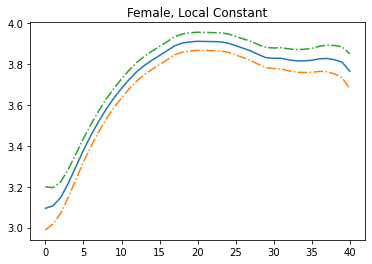

In [60]:
data_temp = data_new2[data_new2.female == 0]
Y = data_temp.lwage
X = data_temp.experience

x = np.array([i for i in range(41)])
res = MyKernelRegression(Y=Y,X=X)
res.fit(x, reg_type='ll')
res.plot(title='Female, Local Constant')

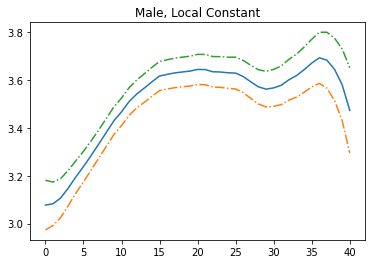

In [61]:
data_temp = data_new2[data_new2.female == 1]
Y = data_temp.lwage
X = data_temp.experience

x = np.array([i for i in range(41)])
res = MyKernelRegression(Y=Y,X=X)
res.fit(x, reg_type='ll')
res.plot(title='Male, Local Constant')